# Perceptron via Torch!

In [1]:
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)  
(x_train_raw, y_train_raw),(x_test_raw, y_test_raw) = MnistDataloader(
    "data/mnist/train-images.idx3-ubyte",
    "data/mnist/train-labels.idx1-ubyte",
    "data/mnist/t10k-images.idx3-ubyte",
    "data/mnist/t10k-labels.idx1-ubyte"
    ).load_data()


In [244]:
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [3]:
x_train = torch.tensor(np.array(x_train_raw).reshape(60000, 28*28))
y_train = torch.tensor(np.array(y_train_raw))
x_test = torch.tensor(np.array(x_test_raw).reshape(10000, 28*28))
y_test = torch.tensor(np.array(y_test_raw))
x_train.shape, y_train.shape, x_train.dtype

(torch.Size([60000, 784]), torch.Size([60000]), torch.uint8)

In [218]:
model = nn.Sequential(
    nn.Linear(28*28, 10),
    nn.Sigmoid()
)
# er_f = nn.HuberLoss()
er_f = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=0.01)


In [182]:
N = 10000
for x, y in zip(x_train[:N], y_train[:N]):
    target = torch.ones(10) * -1
    target[int(y)] = 1
    # y_pred = torch.argmax(y_pred)
    optim.zero_grad()
    train = Variable(x.float(), requires_grad=True)
    target = Variable(target.float(), requires_grad=False)
    y_pred = model(train).float()
    loss = er_f(y_pred, target)
    loss.backward()
    optim.step()

In [209]:
target = torch.ones(x_train.shape[0], 10) * 0
for i, y in zip(range(x_train.shape[0]), y_train):
    target[i, int(y)] = 1
target = Variable(target.float(), requires_grad=False)
train = Variable(x_train.float(), requires_grad=True)

In [229]:
for epich in range(1000):
    optim.zero_grad()
    y_pred = model(train).float()
    loss = er_f(y_pred, target)
    loss.backward()
    optim.step()
    print(loss)

tensor(1.5851, grad_fn=<DivBackward1>)
tensor(1.5849, grad_fn=<DivBackward1>)
tensor(1.5849, grad_fn=<DivBackward1>)
tensor(1.5848, grad_fn=<DivBackward1>)
tensor(1.5848, grad_fn=<DivBackward1>)
tensor(1.5846, grad_fn=<DivBackward1>)
tensor(1.5846, grad_fn=<DivBackward1>)
tensor(1.5844, grad_fn=<DivBackward1>)
tensor(1.5845, grad_fn=<DivBackward1>)
tensor(1.5843, grad_fn=<DivBackward1>)
tensor(1.5844, grad_fn=<DivBackward1>)
tensor(1.5844, grad_fn=<DivBackward1>)
tensor(1.5845, grad_fn=<DivBackward1>)
tensor(1.5846, grad_fn=<DivBackward1>)
tensor(1.5843, grad_fn=<DivBackward1>)
tensor(1.5843, grad_fn=<DivBackward1>)
tensor(1.5842, grad_fn=<DivBackward1>)
tensor(1.5842, grad_fn=<DivBackward1>)
tensor(1.5839, grad_fn=<DivBackward1>)
tensor(1.5839, grad_fn=<DivBackward1>)
tensor(1.5838, grad_fn=<DivBackward1>)
tensor(1.5837, grad_fn=<DivBackward1>)
tensor(1.5836, grad_fn=<DivBackward1>)
tensor(1.5835, grad_fn=<DivBackward1>)
tensor(1.5834, grad_fn=<DivBackward1>)
tensor(1.5832, grad_fn=<D

KeyboardInterrupt: 

In [230]:
torch.eq(torch.argmax(model(x_test.float()), 1), y_test).sum() / len(y_test)

tensor(0.8753)

<BarContainer object of 10 artists>

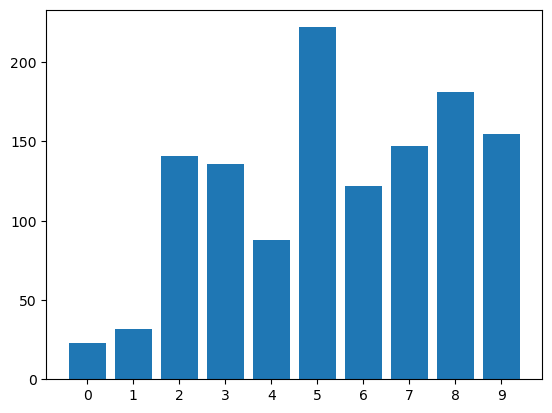

In [248]:
errors = {i: 0 for i in range(10)}
for true, predicted in zip(y_test, torch.argmax(model(x_test.float()), 1)):
    true = int(true)
    errors[true] += true != int(predicted)
plt.xticks(range(10))
plt.bar(errors.keys(), errors.values())